# Recurrent Neural Network Implementation from Scratch



In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class RNNScratch(d2l.Module):  
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

The `forward` method below defines how to compute 
the output and hidden state at any time step,
given the current input and the state of the model
at the previous time step

In [6]:
@d2l.add_to_class(RNNScratch)  
def forward(self, inputs, state=None):
    if state is not None:
        state, = state
    outputs = []
    for X in inputs:
        state = torch.tanh(torch.matmul(X, self.W_xh) + (
            torch.matmul(state, self.W_hh) if state is not None else 0)
                         + self.b_h)
        outputs.append(state)
    return outputs, state

batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

def check_len(a, n):  
    assert len(a) == n, f'list\'s len {len(a)} != expected length {n}'

def check_shape(a, shape):  
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

d2l.check_len(outputs, num_steps)
d2l.check_shape(outputs[0], (batch_size, num_hiddens))
d2l.check_shape(state, (batch_size, num_hiddens))

class RNNLMScratch(d2l.Classifier):  
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

One-Hot Encoding

In [7]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

The minibatches that we sample at each iteration
will take the shape (batch size, number of time steps).
Once representing each input as a one-hot vector,
we can think of each minibatch as a three-dimensional tensor, 
where the length along the third axis 
is given by the vocabulary size (`len(vocab)`)

In [9]:
@d2l.add_to_class(RNNLMScratch)  
def one_hot(self, X):
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

@d2l.add_to_class(RNNLMScratch)  
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)  
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

Check whether the forward computation
produces outputs with the correct shape

In [10]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
d2l.check_shape(outputs, (batch_size, num_steps, num_inputs))

Gradient Clipping
$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$

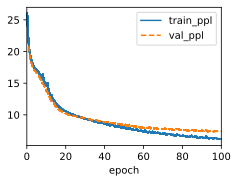

In [12]:
@d2l.add_to_class(d2l.Trainer)  
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

The following `predict` function
generates a continuation, one character at a time,
after ingesting a user-provided `prefix`

In [14]:
@d2l.add_to_class(RNNLMScratch)  
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:
            outputs.append(vocab[prefix[i + 1]])
        else:
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has and the the the the'